## <a name="abstract">Titanic Machine Learning From Disaster</a>

Abstract The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [1]:
using DataFrames
using DecisionTree
using Iterators
using GLM
using Gadfly
import StatsBase.predict

# Scikit
using PyCall
@pyimport sklearn.neighbors.nearest_centroid as nearest_centroid
@pyimport numpy as np
@pyimport sklearn.linear_model as sklm
@pyimport sklearn.svm as svm
@pyimport sklearn.naive_bayes as naive_bayes
@pyimport sklearn.ensemble as ensemble

### Load Preprocessed Data

In [2]:
label = :Survived
features = [:Pclass, :Sex, :Age, :SibSp, :Parch, :Fare, :Embarked,
            :Title, :FamilySize, :IsMother, :IsChild, :IsSmallFamily,
            :CabinPrefix, :CabinNumber]

train = readtable("./data/train_enriched.tsv", separator='\t')[:, [features, label]]
test_passengers_id = readtable("./data/test_enriched.tsv", separator='\t')[:, :PassengerId]
test = readtable("./data/test_enriched.tsv", separator='\t')[:, features];

In [3]:
split = int(size(train, 1)*.8)
train80 = train[1:split, :]
train20 = train[split+1:end, :];

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/diego/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/diego/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[2], in expression starting on line 6


In [4]:
binarize{T <: Number}(y::Array{T,1}) = Array{Int8,1}(y .>= .5)
binarize{T <: Integer}(y::T) = y >= .5? 1 : 0

function calc_accuracy{T <: Integer}(y_real::Array{T,1}, y_pred::Array{T,1})
    nrows = length(y_real)
    preds_diff = map(i -> y_real[i] == binarize(y_pred[i])?1:0, vcat(1:nrows))
    return round(sum(preds_diff)/nrows, 2)  
end

function calc_accuracy{T <: Integer}(y_real::Array{T,1}, y_preds::Array{Array{T,1},1})
    return map(y_pred -> calc_accuracy(Array{Int8}(y_real), Array{Int8}(y_pred)), y_preds)
end

function predictions_to_matrix(predictions)
    nrows = length(predictions[1])
    ncols = length(predictions)
    return reshape(vcat(predictions...), (nrows, ncols))
end

function average_predictions(predictions_matrix)
    final_predictions = []
    ncols = size(predictions_matrix, 2)
    for row = 1:size(predictions_matrix, 1)
        push!(final_predictions, sum(predictions_matrix[row, :])/ncols >= .5? 1 : 0)
    end
    return Array{Int8,1}(final_predictions)
end

 in depwarn at deprecated.jl:73
 in int at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/diego/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/diego/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 1


average_predictions (generic function with 1 method)

## Training

### Logistic Regression

In [67]:
linear_model = glm(Survived ~ Pclass + Sex + Age + Parch + Fare + 
                              Embarked + Title + FamilySize + IsMother + 
                              IsSmallFamily + CabinPrefix + CabinNumber, train80, Binomial());

### Random Forest

In [6]:
rf_model = build_forest(array(train80[label]), array(train80[:, features]), 5, 500);

### kNN

In [7]:
knn_model = nearest_centroid.NearestCentroid()
knn_model[:fit](array(train80[:, features]), array(train80[label]));

### Lasso

In [1]:
lasso_model = sklm.Lasso(alpha = 0.1)
lasso_model[:fit](array(train80[:, features]), array(train80[label]));

LoadError: LoadError: UndefVarError: sklm not defined
while loading In[1], in expression starting on line 1

### SVM

In [9]:
svm_model = svm.SVC()
svm_model[:fit](array(train80[:, features]), array(train80[label]));

### SGD

In [10]:
sgd_model = sklm.SGDClassifier(loss="hinge", penalty="l2")
sgd_model[:fit](array(train80[:, features]), array(train80[label]));

### Naive Bayes

In [11]:
naive_bayes_model = naive_bayes.GaussianNB()
naive_bayes_model[:fit](array(train80[:, features]), array(train80[label]));

### Extremely Randomized Trees

In [12]:
extremely_rand_tress_models = ensemble.ExtraTreesClassifier(n_estimators=10, min_samples_split=1, random_state=0)
extremely_rand_tress_models[:fit](array(train80[:, features]), array(train80[label]));

### Evaluate Training

In [87]:
predicts(model::PyObject, df::DataFrame) = binarize(model[:predict](array(df)))
predicts(model, df::DataFrame) = binarize(array(predict(model, df)))
predicts(model::DecisionTree.Ensemble, df::DataFrame) = apply_forest(model, array(df))
calc_accuracies(groundtruth, predictions) = map(p -> calc_accuracy(Array{Int8}(groundtruth), Array{Int8}(p)), predictions)

calc_accuracies (generic function with 1 method)

In [37]:
model_names = [:LR, :RF, :kNN, :Lasso, :SVM, :SGD, :NaiveBayes, :ExtremelyRandTrees]
models = [linear_model, rf_model, knn_model, lasso_model, svm_model, 
          sgd_model, naive_bayes_model, extremely_rand_tress_models];

#### Training/Validation Evaluation

In [48]:
# Training Evaluation
groundtruth = Array{Int8}(train80[label])
training_predicts = Array[predicts(m, train80) for m in models]
training_accs = calc_accuracies(groundtruth, training_predicts);

# Validation Evaluation
groundtruth = Array{Int8}(train20[label])
validation_predicts = Array[predicts(m, train20) for m in models]
validation_accs = calc_accuracies(groundtruth, validation_predicts);

results = DataFrame(model=model_names, acc_training=training_accs, 
                    acc_validation=validation_accs, 
                    diff=round(validation_accs-training_accs, 2))

,model,acc_training,acc_validation,diff
1,LR,0.8,0.85,0.05
2,RF,0.94,0.87,-0.07
3,kNN,0.65,0.75,0.1
4,Lasso,0.7,0.75,0.05
5,SVM,0.93,0.78,-0.15
6,SGD,0.68,0.71,0.03
7,NaiveBayes,0.78,0.8,0.02
8,ExtremelyRandTrees,0.98,0.82,-0.16


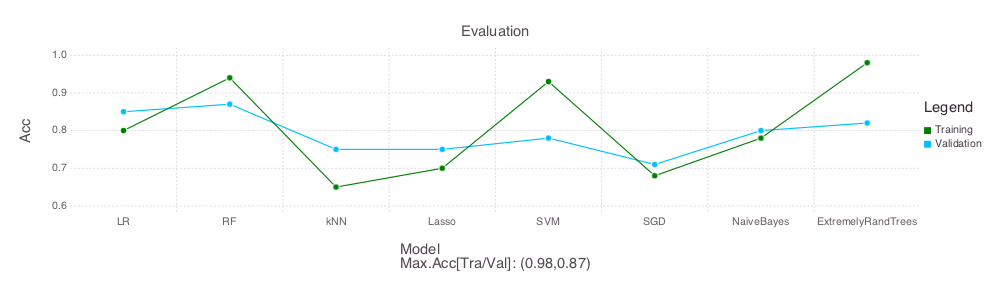

In [152]:
set_default_plot_size(1000px, 300px)
plot(results, Scale.x_discrete, 
Guide.xlabel("Model\nMax.Acc[Tra/Val]: $((maximum(results[:acc_training]),maximum(results[:acc_validation])))"), 
     Guide.ylabel("Acc"), Guide.title("Evaluation"),
     layer(x="model", y="acc_training", Geom.line, Geom.point, 
           Theme(default_color=colorant"green")),
     layer(x="model", y="acc_validation", Geom.line, Geom.point),
     Guide.manual_color_key("Legend", ["Training", "Validation"], ["green", "deepskyblue"]))

### Stacking Ensemble

In [165]:
stacking_features = [:x1, :x2, :x3, :x4, :x5, :x6, :x7, :x8]
training_stacking = DataFrame(reshape(vcat(training_predicts...), (8, length(training_predicts[1])))')
training_stacking[:y] = train80[label]
stacking_model = glm(y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8, training_stacking, Binomial())
calc_accuracy(Array{Int8}(training_stacking[:y]), Array{Int8}(predicts(stacking_model, training_stacking)))

0.6